# Early Stopping from Foundations

#### Last Time
We're [fresh off of successfully implementing](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/05_anneal_my_reimplementation.ipynb?flush_cache=true) a parameter scheduler callback that can combine any annealing schedules we define (such as cosine annealing), store variations of them, and apply these variations discriminatively to as many of our model's parameter groups as we desire.

#### Early Stopping
Before we [press on toward](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/06_cuda_cnn_hooks_init_my_reimplementation.ipynb?flush_cache=true) learning about how to use the PyTorch hooks that allow us to effectively utilize GPUs to train our models, we're going take a short detour and study a great way to implement early stopping callbacks.

There are various conditions that could arise during model training that might make it necessary for us to abort an individual stage of the training cycle -- we may find it necessary to cancel training of a particular batch or epoch and move onto the next one. There may even be times when we'd want to cancel the whole training cycle, outright.

For example, if our model's validation loss begins to rise for a given number (we get to decide on the exact threshold) of consecutive iterations (after having been on a declining trend), we might want to halt the training cycle as we could reasonably conclude that our model is in over-fitting territory.

As with all in-flight adjustments to our deep learning models that are made during training, we utilize callbacks to cancel all or part of a training cycle. In this notebook we'll demonstrate a clever way of using Python exception handlers, not to catch errors, but to cancel training.

At the very end, we'll implement a [learning rate finder](https://docs.fast.ai/basic_train.html#lr_find) from scratch. This is the most common scenario in which fastai library users cancel model training mid-fight.

#### Attribution
Virtually all the code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy). The original version of this notebook that they made for the course lecture can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/05b_early_stopping.ipynb). I simply re-typed, line-by-line, the pieces of logic necessary to implement the functionality that their notebook demonstrated. In some cases I changed the order of code cells and or variable names so as to fit an organization and style that seemed more intuitive to me. Any and all mistakes are my own.

On the other hand, all long-form text explanations in this notebook are solely my own creation. Writing extensive descriptions of the concepts and code in plain and simple English forces me to make sure that I actually understand how they work.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_05 import *

### A Better Cancellation Callback

We will create three classes that inherit from Python's `Exception` class. Each of these exception classes will be in charge of cancelling a different aspect of training (epoch, batch, or entire training cycle).

Our `Runner` class that we use to manage training loops will be modified such that its respective methods in charge of managing one batch, one epoch, or the whole training cycle will be able to exit if the appropriate cancellation exception is passed in. Placing each method's logic inside a Python `try:`/`except:` block is what makes this approach possible.

In [3]:
# Set up the MNIST data so we can try out our implementation 
# once we're done.
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

Here are the three exceptions we'll use to cancel training. To say these classes are simple is an understatement:

In [4]:
#export
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

We'll also update the `Callback()` class we wrote in [Notebook 4](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/04_callbacks_my_reimplementation.ipynb?flush_cache=true) and give it a `__call__()` method. This method contains the logic that retrieves the name of a callback and tests to see whether it is being called at a particular points during training.

We had previously performed this check inside the `Runner` class' `__call__` method, where we called the following two lines after looping through each callback in the list of callbacks passed to a `Runner()` object when it is constructed:
```python
f = getattr(self, cb_name, None)
if f and f(): return True
```
Moving these two lines into the `Callback` class' `__call__` method lets us simplify an already somewhat long and rambling `Runner` class.

To compare and contrast, this is what our `Runner` class' `__call__` method used to look like:
```python
def __call__(self, cb_name):
    for cb in sorted(self.cbs, key=lambda x: x._order):
        f = getattr(cb, cb_name, None)
        if f and f(): return True
    return False
```
And here's what it looks like now:
```python
def __call__(self, cb_name):
    for cb in sorted(self.cbs, key=lambda x: x._order): cb(cb_name)
```

In [5]:
#export
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

Since we've updated the `Callback` class, we need to re-implement the core `TrainEvalCallback` class as well (even though its own structure has no changes since its most recent implementation) because it will need to inherit from the newest version of the `Callback` class:

In [6]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

And now, our new and improved `Runner` class, complete with `try:`/`except:` blocks:

In [7]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.cbs = [TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
            
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
        
    def fit(self, epochs, learn):
        self.epochs, self.learn, self.loss = epochs, learn, tensor(0.)
        
        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch') 
            
        except CancelTrainException: self('after_cancel_train')
        finally:
                self('after_fit')
                self.learn = None
                
    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order): cb(cb_name)

We'll test this out with a `TestCallback` class that will cancel training after 10 iterations have been completed:

In [8]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=9: raise CancelTrainException()

In [9]:
learn = create_learner(get_model, loss_func, data)
run = Runner(cb_funcs=TestCallback)

In [10]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9


### Reimplement `AvgStatsCallback`, `ParamScheduler`, and `Recorder` Callbacks
These other three callback methods that each inherit from the `Callback` class also need to be reimplemented since we want them to inherit from our new and improved `Callback` class instead of its predecessor. 

While `AvgStatsCallback`and `ParamScheduler` are identical to their previous implementations, we have added an improvement to `Recorder`. It now contains a new method, `plot`, that plots learning rates in log-scale on the x-axis, and loss on the y-axis. We can call this method after running the soon-to-be-created learning rate finder class to display a graph of how our model's loss varies with learning rate. 

In [11]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,in_train=True), AvgStats(metrics,in_train=False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [12]:
#export
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            # Apply same sched func to each param group if only one 
            # sched func is passed.
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
            
    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        # If list of sched funcs is passed, apply each sched func 
        # corresponding pram group
        for pg,f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, slip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=10, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

### Learning Rate Finder
As promised, we will now implement a class that'll help us to find the ideal learning rate. The gist of it is that we train our model for 100 iterations, incrementally increasing the learning rate from a minimum of `1e-6` to a maximum of `10`. We record the loss after each iteration and if an iteration's loss is at least ten times higher than the lowest loss we've so far observed, we cancel training (using the `CancelTrainException` that we defined earlier).

Feel free to reference Leslie Smith's [2015 paper](https://arxiv.org/abs/1506.01186) that introduced this technique for further details. The basic rule of thumb is that we pick the learning rate from the range of values just prior to the point where loss begins to increase. As for which specific value we ultimately decide on: choose the point from this range where rate of decline is steepest.

In [14]:
#export
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

Note that this implementation is quite similar to the way it's done in the [fastai library](https://docs.fast.ai/basic_train.html#lr_find) with one difference: fastai uses exponential smoothing when displaying the loss, so instead of checking at a threshold of `best_loss*10`, fastai uses `best_loss*3`.

In [15]:
learn = create_learner(get_model, loss_func, data)
run = Runner(cb_funcs=[LR_Find, Recorder])

In [16]:
run.fit(2, learn)

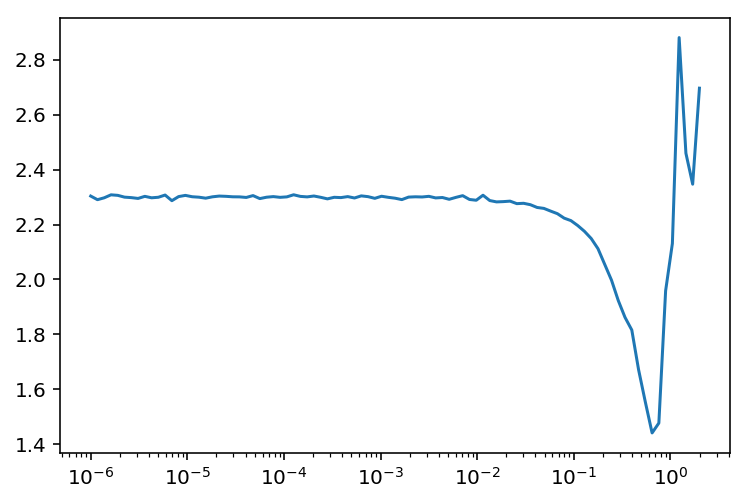

In [17]:
run.recorder.plot(skip_last=5)

Based on our rule of thumb, it looks like the ideal learning rate with which to start training our model would be around `5e-1`.

Below we can see how our learning rate varied across each iteration during which we ran our learning rate finder:

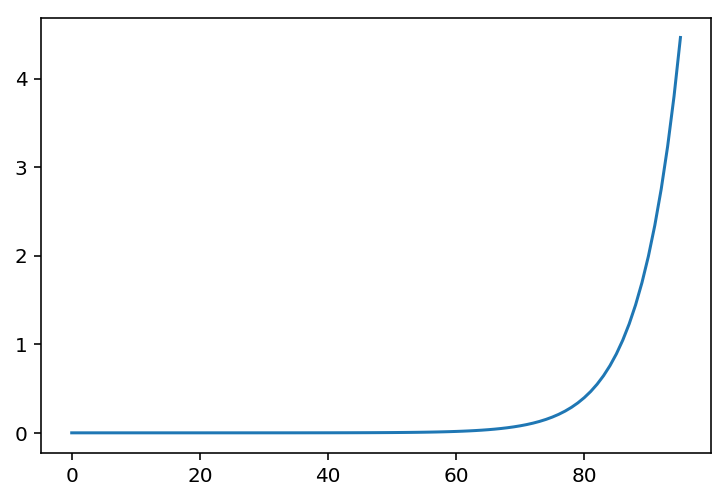

In [18]:
run.recorder.plot_lr()

### Export

In [19]:
!python notebook2script_my_reimplementation.py 05b_early_stopping_my_reimplementation.ipynb

Converted 05b_early_stopping_my_reimplementation.ipynb to nb_05b.py
